# Imports

In [1]:
import os
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from cmcrameri import cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import joblib

# Set seeds
import random
random.seed(42)

# data_path=  Path('../../../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_spat_NH')
# attributes_path = data_path / 'camels_spat_attributes_to_nh.csv'

data_path =  Path('../../../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_US')
attributes_path = data_path / 'camels_attributes_v2.0'

data_path_camels_us = Path('../../../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_US')
map_shape_file = data_path_camels_us / 'basin_set_full_res/usa-states-census-2014.shp'
hm_catchment = data_path_camels_us / 'basin_set_full_res/HCDN_nhru_final_671.shp'


USE_ELBOW_METHOD = False
USE_SILHOUETTE_METHOD = False

# Parameters and constants

In [2]:
file_name = '569_basin_file.txt'

basin_file = Path(file_name)

stactic_camels_us = [
    'elev_mean',
    'slope_mean',
    'area_gages2',
    'frac_forest',
    'lai_max',
    'lai_diff',
    'gvf_max',
    'gvf_diff',
    'soil_depth_pelletier',
    'soil_depth_statsgo',
    'soil_porosity',
    'soil_conductivity',
    'max_water_content',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'carbonate_rocks_frac',
    'geol_permeability',
    'p_mean',
    'pet_mean',
    'aridity',
    'frac_snow',
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur',
    'p_seasonality'
]

stactic_camels_spat = [
    'aridity1_mean',
    'fracsnow1_mean',
    'seasonality1_mean',
    'low_prec_dur_mean',
    'high_prec_freq',
    'high_prec_dur_mean',
    'prec_mean',
    'pet_mean',
    'basin_area',
    'elev_mean',
    'slope_mean',
    'soil_thickness_mean',
    'porosity_mean',
    'log_permeability_mean',
    'lai_mean_month_max',
    'lai_mean_month_diff',
    'sand_layer_mean',
    'silt_layer_mean',
    'clay_layer_mean'
]

# Define custom colors for clusters to match the image
cluster_colors = {
    0: '#1f77b4',  # Blue
    1: '#ff7f0e',  # Orange
    2: '#2ca02c',  # Green
    3: '#d62728',  # Red
    4: '#9467bd',  # Purple
    5: '#8c564b',  # Brown
    6: '#e377c2',  # Pink
    7: '#7f7f7f',  # Gray
    8: '#bcbd22',  # Yellow
    9: '#17becf'  # Cyan
}

# Load data

In [3]:
# Load the basin list
with open(basin_file, 'r') as f:
    basins = f.read().splitlines()

# Check if attributes_path is a file or a directory
if attributes_path.is_file():
    # Load the CAMELS_spat attributes
    attrs_df = pd.read_csv(attributes_path)
    static_list = stactic_camels_spat
    attrs_df = attrs_df[['basin'] + static_list]
    ds_name = 'CAMELS-SPAT'
else:
    # Load the CAMELS attributes
    if not attributes_path.exists():
        raise RuntimeError(f"Attribute folder not found at {attributes_path}")

    txt_files = attributes_path.glob('camels_*.txt')

    # Read-in attributes into one big dataframe
    dfs = []
    for txt_file in txt_files:
        df_temp = pd.read_csv(txt_file, sep=';', header=0, dtype={'gauge_id': str})
        df_temp = df_temp.set_index('gauge_id')

        dfs.append(df_temp)

    attrs_df = pd.concat(dfs, axis=1)
    # convert huc column to double digit strings
    attrs_df['huc'] = attrs_df['huc_02'].apply(lambda x: str(x).zfill(2))
    attrs_df = attrs_df.drop('huc_02', axis=1)

    if basins:
        if any(b not in attrs_df.index for b in basins):
            raise ValueError('Some basins are missing static attributes.')
        attrs_df = attrs_df.loc[basins]

    # Remove index and Substitute gauge_id for basin
    attrs_df = attrs_df.reset_index().rename(columns={'gauge_id': 'basin'})

    # Filter the CAMELS static attributes
    static_list = stactic_camels_us
    attrs_df = attrs_df[['basin'] + static_list]
    ds_name = 'CAMELS-US'


# Filter the CAMELS spatial attributes to only include the basins in the basin list
attrs_df = attrs_df[attrs_df['basin'].isin(basins)]

display(
    # attrs_df.columns,
    attrs_df
)

,basin,elev_mean,slope_mean,area_gages2,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,soil_depth_pelletier,...,geol_permeability,p_mean,pet_mean,aridity,frac_snow,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,p_seasonality
0,01013500,250.31,21.64152,2252.70,0.9063,4.167304,3.340732,0.804567,0.371648,7.404762,...,-14.7019,3.126679,1.971555,0.630559,0.313440,12.95,1.348958,202.20,3.427119,0.187940
1,01022500,92.68,17.79072,573.60,0.9232,4.871392,3.746692,0.863936,0.337712,17.412808,...,-14.2138,3.608126,2.119256,0.587356,0.245259,20.55,1.205279,233.65,3.662226,-0.114530
2,01030500,143.80,12.79195,3676.17,0.8782,4.685200,3.665543,0.858502,0.351393,19.011414,...,-14.4918,3.274405,2.043594,0.624111,0.277018,17.15,1.207746,215.60,3.514262,0.047358
3,01031500,247.80,29.56035,769.05,0.9548,4.903259,3.990843,0.870668,0.398619,7.252557,...,-14.8410,3.522957,2.071324,0.587950,0.291836,18.90,1.148936,227.35,3.473644,0.104091
4,01047000,310.38,49.92122,909.10,0.9906,5.086811,4.300978,0.891383,0.445473,5.359655,...,-14.4819,3.323146,2.090024,0.628929,0.280118,20.10,1.165217,235.90,3.691706,0.147776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,14306500,308.31,57.46785,857.16,0.9993,3.771918,1.972874,0.859425,0.133282,1.060140,...,-14.6983,6.286938,2.963947,0.471445,0.020298,13.95,1.800000,193.00,5.857360,-0.955287
565,14309500,709.83,110.42527,224.92,1.0000,4.227902,1.986325,0.883414,0.115741,0.894595,...,-14.8976,4.977781,3.122204,0.627228,0.061255,15.10,1.776471,222.65,6.893189,-0.995847
566,14316700,952.26,119.08920,587.90,1.0000,4.859652,2.828735,0.914354,0.171176,0.879292,...,-13.5958,4.543400,2.277630,0.501305,0.176337,14.75,1.446078,214.85,6.018207,-0.821172
567,14325000,656.53,124.96889,443.07,1.0000,4.150730,1.867148,0.873517,0.115977,0.990318,...,-15.1799,6.297437,2.434652,0.386610,0.030203,14.60,1.467337,219.05,6.240741,-0.952055


# Clustering

## Prepare data

In [4]:
# Select the columns to be used for clustering - all but basin
X = attrs_df.drop(columns=['basin'])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Elbow curve

In [5]:
if USE_ELBOW_METHOD:
    # Determine the optimal number of clusters using the Elbow method
    sse = []
    for k in range(2, 21):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        sse.append(kmeans.inertia_)

    # Plot the Elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 20, 1), sse, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Determining Optimal Number of Clusters')
    plt.grid(True)
    plt.show()

## Silhouette score

In [6]:
if USE_SILHOUETTE_METHOD:
    # Determine the optimal number of clusters using the silhouette score
    silhouette_scores = []
    range_n_clusters = range(2, 21)
    for k in range_n_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.grid(True)
    plt.show()

# K-means

In [32]:
# From the Elbow plot, choose the optimal number of clusters (e.g., k=4)
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)

# Fit the model to the data (assuming X_scaled is your scaled feature matrix)
kmeans.fit(X_scaled)

# Save the trained KMeans model
model_filename = 'kmeans_569basins_model.pkl'
joblib.dump(kmeans, model_filename)

# Save the scaler
scaler_filename = 'kmeans_569basins_scaler.pkl'
joblib.dump(scaler, scaler_filename)

# Assign clusters to the data
attrs_df['cluster'] = kmeans.predict(X_scaled)

cluster_counts = attrs_df['cluster'].value_counts().sort_index().to_dict()

# Save the attributes to a csv file
attrs_df.to_csv(data_path / (ds_name.lower() + f'_attributes_clusters_{len(attrs_df)}basins.csv'), index=False)

# Save files with list of basins in each cluster
for cluster in range(optimal_k):
    basins_in_cluster = attrs_df[attrs_df['cluster'] == cluster]['basin'].values
    with open(f'{len(attrs_df)}_basin_file_cluster{cluster+1}of{optimal_k}_{cluster_counts[cluster]}.txt', 'w') as f:
        f.write('\n'.join(basins_in_cluster))

display(
    attrs_df['cluster'].value_counts()
)

cluster
0    138
3     85
1     71
6     63
2     59
5     57
4     57
7     39
Name: count, dtype: int64

## Plot map

### Load and repoject map files

In [33]:
# Load basin coordinates (hm_catchment)
hm_catchment_gdf = gpd.read_file(hm_catchment)

# hru_id values to be string type of 8 characters with leading zeros
hm_catchment_gdf['hru_id'] = hm_catchment_gdf['hru_id'].astype(str).str.zfill(8)

# Filter hm_catchment_gdf to only include the HRU_IDs in the hm_catchment['basin'] column
hm_catchment_gdf = hm_catchment_gdf[hm_catchment_gdf['hru_id'].isin(attrs_df['basin'])]

In [34]:
states = gpd.read_file(map_shape_file)

# Define the CRS of your original data (if it's not already defined)
original_crs = 'EPSG:4326'  # Assuming WGS84 geographic CRS

states = gpd.read_file(map_shape_file)
# Set the CRS for the GeoDataFrame
states.crs = original_crs

# Define the new CRS you want to reproject to, for example, an Albers Equal Area projection
target_crs = 'ESRI:102008'  # ESRI:102008 is the WKID for the Albers Equal Area projection

# Reproject the GeoDataFrame
states_reprojected = states.to_crs(target_crs)

In [35]:
# Reproject the catchment GeoDataFrame
hm_catchment_gdf_reprojected = hm_catchment_gdf.to_crs(states_reprojected.crs)

# Reproject the coordinates of the circles
basin_coordinates_reprojected = gpd.points_from_xy(hm_catchment_gdf['lon_cen'], hm_catchment_gdf['lat_cen'], crs='EPSG:4326')
basin_coordinates_reprojected = gpd.GeoDataFrame(geometry=basin_coordinates_reprojected, crs='EPSG:4326')
basin_coordinates_reprojected = basin_coordinates_reprojected.to_crs(states_reprojected.crs)

### Plot

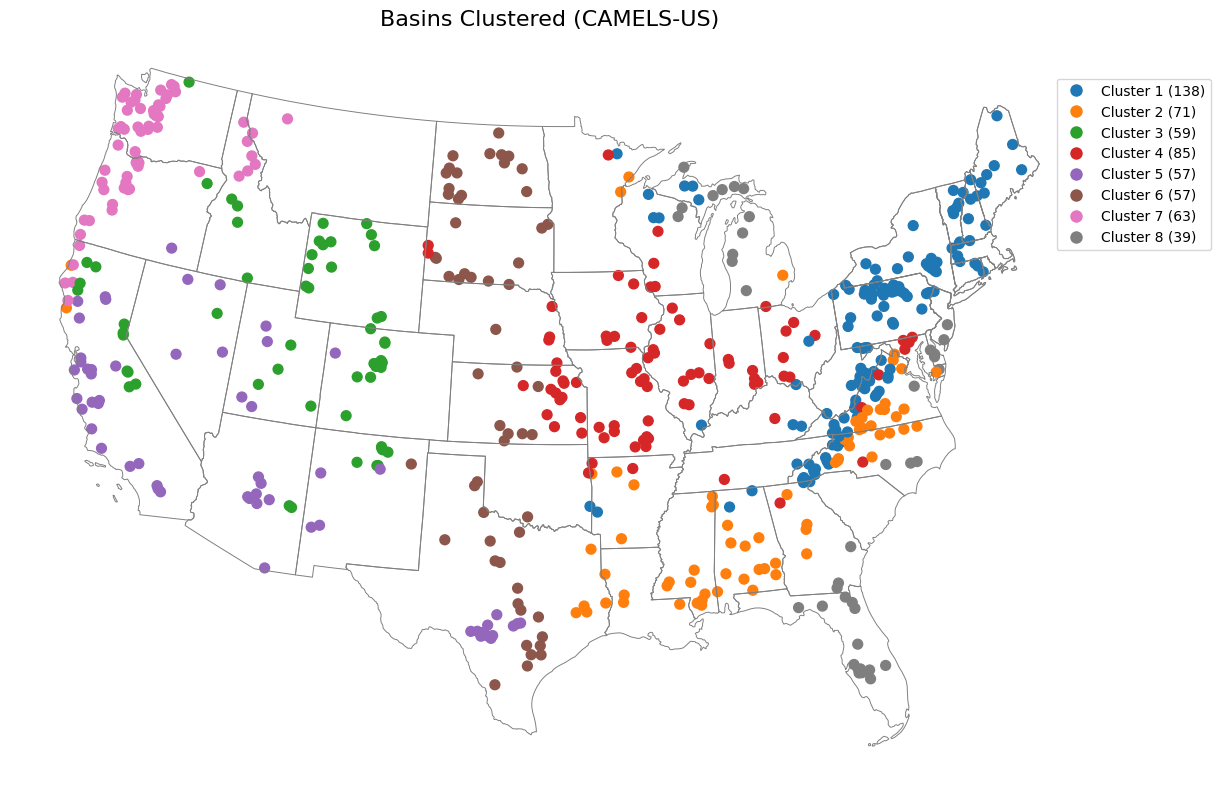

In [36]:
# Merge attrs_df with basin_coordinates_reprojected based on the index
basin_coordinates_reprojected['cluster'] = attrs_df['cluster'].values

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 8))

# Plot state boundaries
states_reprojected.boundary.plot(ax=ax, color=None, edgecolor='gray', linewidth=0.7)

# # Create a discrete colormap
# cmap = cm.glasgow  # Choose 'rain' or another colormap from cmocean

# Create a colormap and norm from the custom colors
cmap_colors = [cluster_colors[i] for i in sorted(cluster_colors.keys())[:optimal_k]]
cmap = mcolors.ListedColormap(cmap_colors)

# Plot each basin as a circle with color determined by the cluster
basin_coordinates_reprojected.plot(ax=ax, marker='o', column='cluster', cmap=cmap, markersize=50)

# # Plot each basin as a circle with color determined by the cluster
# for cluster, color in cluster_colors.items():
#     basin_coordinates_reprojected[basin_coordinates_reprojected['cluster'] == cluster].plot(
#         ax=ax, marker='o', color=color, markersize=50, label=f'Cluster {cluster}'
#     )

# Add custom legend with circular markers
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {i+1} ({cluster_counts[i]})') \
           for i, color in cluster_colors.items() if i < optimal_k]
ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.12, 0.95))

# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])

# Get rid of box lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add a title
plt.title(f'Basins Clustered ({ds_name})', fontsize=16)

# Tight layout with reduced padding
plt.tight_layout()

# # Adjust bounding box to reduce white space
# fig.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.01)

# Save the plot
plt.savefig(f'{len(attrs_df)}_basins_clusters_{optimal_k}clusters.png', dpi=150, bbox_inches='tight')

# Show plot
plt.show()